# Predict smoothed female velocity inferred neural population activity.

Using ridge regression

In [1]:
%matplotlib inline
import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy import stats
from sklearn import linear_model
import sys

from disp import set_plot
from my_torch import skl_fit_ridge

cc = np.concatenate

STRAINS = ['NM91', 'ZH23']
PTRAIN = .8
NSPLIT = 30

# NRL_MDL = 'lin'  # linear neural model
# NRL_MDL = 'lin2e'  # linear neural model (two-exp fit)
# NRL_MDL = 'linr'  # linear neural model (fit w ridge regr)
# NRL_MDL = 'ln'  # linear-nonlinear model
# NRL_MDL = 'ln2e'  # linear-nonlinear model (two-exp fit)
# NRL_MDL = 'lnr'  # linear-nonlinear model (fit w ridge regr)
# NRL_MDL = 'dyn'  # dynamical neural model
NRL_MDL = 'masoff'  # dynamical neural model

TARGS = ['FFV_MN_60', 'FFV']
# TARGS = ['FLS_MN_60', 'FLS']

FIT_LIN = skl_fit_ridge

ALPHA = 10
FIT_KWARGS = {'alpha': ALPHA}

In [2]:
FSTRAIN = 'data/simple/strains.csv'
FBAKER_FIT_PARAM = f'data/simple/neur/baker_{NRL_MDL}_fit_param.csv'

FPFX_NEUR_BHV = f'data/simple/mlv/neur_basic/baker_{NRL_MDL}/mlv_baker_{NRL_MDL}'
FPFX_BHV_XTD = f'data/simple/behav_xtd/behav_xtd'

FSAVE = f'data/simple/mlv/neur_basic/baker_{NRL_MDL}_{"_".join(STRAINS).lower()}_{TARGS[0].lower()}_ridge_alpha_{ALPHA}.npy'

DFBAKER_FIT_PARAM = pd.read_csv(FBAKER_FIT_PARAM)
R_COLS_USE = [f'R_{ir}' for ir in DFBAKER_FIT_PARAM.EXPT_ID]

MSTRAINS = [(pd.read_csv(FSTRAIN)['STRAIN'] == strain) for strain in STRAINS]
MSTRAIN = np.any(MSTRAINS, axis=0)
ISTRAIN = MSTRAIN.nonzero()[0]

NTR = MSTRAIN.sum()
NTRAIN = int(round(PTRAIN*NTR))

In [3]:
# fit regression models
rslts = []
for csplit in range(NSPLIT):
    print(f'Split {csplit}')
    irnd = np.random.permutation(NTR)
    idxs_train = ISTRAIN[irnd[:NTRAIN]]
    idxs_test = ISTRAIN[irnd[NTRAIN:]]
    if csplit < 2:
        rslt = FIT_LIN([FPFX_NEUR_BHV, FPFX_BHV_XTD], R_COLS_USE, TARGS, idxs_train, idxs_test, return_y=True, **FIT_KWARGS)
    else:
        rslt = FIT_LIN([FPFX_NEUR_BHV, FPFX_BHV_XTD], R_COLS_USE, TARGS, idxs_train, idxs_test, return_y=False, **FIT_KWARGS)
    rslts.append(rslt)

Split 0
Loading...
Fitting...
>>Split 1
Loading...
Fitting...
>>Split 2
Loading...
Fitting...
>>Split 3
Loading...
Fitting...
>>Split 4
Loading...
Fitting...
>>Split 5
Loading...
Fitting...
>>Split 6
Loading...
Fitting...
>>Split 7
Loading...
Fitting...
>>Split 8
Loading...
Fitting...
>>Split 9
Loading...
Fitting...
>>Split 10
Loading...
Fitting...
>>Split 11
Loading...
Fitting...
>>Split 12
Loading...
Fitting...
>>Split 13
Loading...
Fitting...
>>Split 14
Loading...
Fitting...
>>Split 15
Loading...
Fitting...
>>Split 16
Loading...
Fitting...
>>Split 17
Loading...
Fitting...
>>Split 18
Loading...
Fitting...
>>Split 19
Loading...
Fitting...
>>Split 20
Loading...
Fitting...
>>Split 21
Loading...
Fitting...
>>Split 22
Loading...
Fitting...
>>Split 23
Loading...
Fitting...
>>Split 24
Loading...
Fitting...
>>Split 25
Loading...
Fitting...
>>Split 26
Loading...
Fitting...
>>Split 27
Loading...
Fitting...
>>Split 28
Loading...
Fitting...
>>Split 29
Loading...
Fitting...
>>

In [4]:
# save r2, weights, and example predictions
save_data = {
    'r2_train': {targ: np.array([rslt.r2_train[targ] for rslt in rslts]) for targ in TARGS},
    'r2_test': {targ: np.array([rslt.r2_test[targ] for rslt in rslts]) for targ in TARGS},
    'w': {targ: np.array([rslt.w[targ] for rslt in rslts]) for targ in TARGS},
    'ys_train': {targ: [rslt.ys_train[targ] for rslt in rslts[:2]] for targ in TARGS},
    'ys_test': {targ: [rslt.ys_test[targ] for rslt in rslts[:2]] for targ in TARGS},
    'y_hats_train': {targ: [rslt.y_hats_train[targ] for rslt in rslts[:2]] for targ in TARGS},
    'y_hats_test': {targ: [rslt.y_hats_test[targ] for rslt in rslts[:2]] for targ in TARGS},
    'targs': TARGS,
    'fit_fn': FIT_LIN.__name__,
    'fit_kwargs': FIT_KWARGS,
    'ntr': NTR,
    'nsplit': NSPLIT,
    'nr': len(R_COLS_USE)
}

np.save(FSAVE, np.array([save_data]))

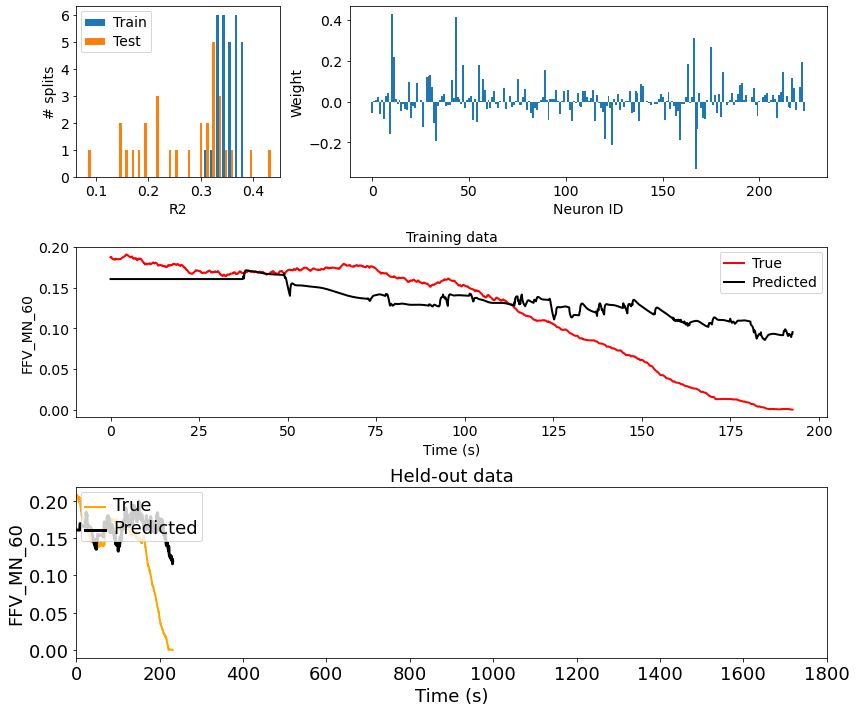

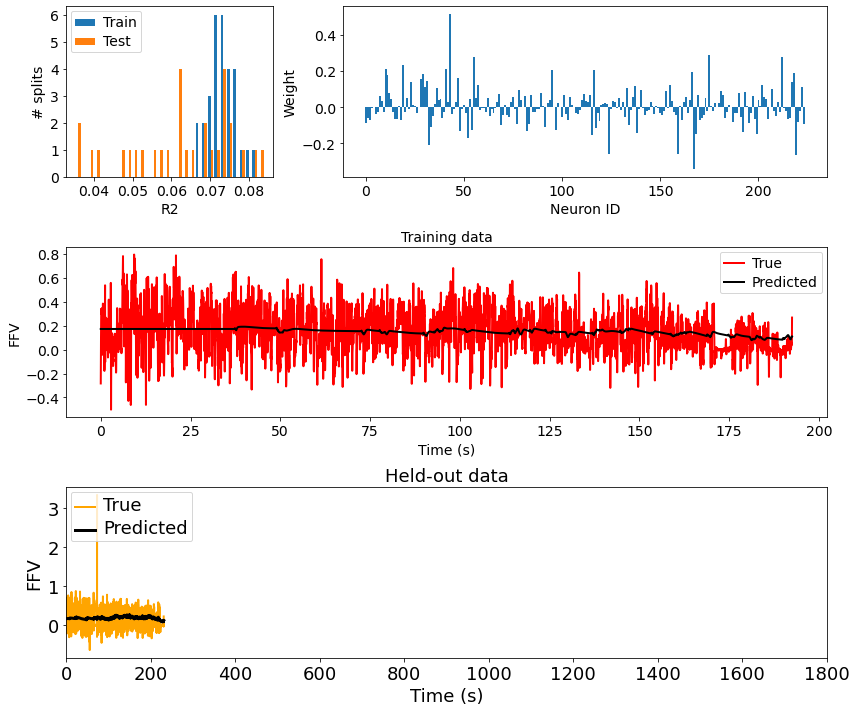

In [5]:
TRAIN_IDX_PLOT = 12
TEST_IDX_PLOT = 6

# for Dyn neurons compare split 0, test idxs 5 & 6 to show how thing being predicted is how quickly F slows down over trial

data = np.load(FSAVE, allow_pickle=True)[0]

for targ in TARGS:
    gs = gridspec.GridSpec(3, 3)

    fig = plt.figure(figsize=(12, 10), tight_layout=True)
    axs = [fig.add_subplot(gs[0, 0]), fig.add_subplot(gs[0, 1:]), fig.add_subplot(gs[1, :]), fig.add_subplot(gs[2, :])]

    axs[0].hist(np.transpose([data['r2_train'][targ], data['r2_test'][targ]]), bins=30)
    axs[0].legend(['Train', 'Test'])
    set_plot(axs[0], x_label='R2', y_label='# splits', font_size=14)

    axs[1].bar(np.arange(data['w'][targ].shape[1]), np.mean(data['w'][targ], axis=0), width=1)
    set_plot(axs[1], x_label='Neuron ID', y_label='Weight', font_size=14)

    axs[2].plot(np.arange(len(data['ys_train'][targ][0][TRAIN_IDX_PLOT]))/30.03, data['ys_train'][targ][0][TRAIN_IDX_PLOT], c='r', lw=2)
    axs[2].plot(np.arange(len(data['y_hats_train'][targ][0][TRAIN_IDX_PLOT]))/30.03, data['y_hats_train'][targ][0][TRAIN_IDX_PLOT], c='k', lw=2)
    axs[2].legend(['True', 'Predicted'])
    set_plot(axs[2], x_label='Time (s)', y_label=targ, title='Training data', font_size=14)

    axs[3].plot(np.arange(len(data['ys_test'][targ][0][TEST_IDX_PLOT]))/30.03, data['ys_test'][targ][0][TEST_IDX_PLOT], c='orange', lw=2)
    axs[3].plot(np.arange(len(data['y_hats_test'][targ][0][TEST_IDX_PLOT]))/30.03, data['y_hats_test'][targ][0][TEST_IDX_PLOT], c='k', lw=3)
    axs[3].legend(['True', 'Predicted'], loc='upper left')
    set_plot(axs[3], x_lim=(0, 1800), x_label='Time (s)', y_label=targ, title='Held-out data', font_size=18)

In [8]:
data['r2_test']['FFV'].mean()

0.06217243116621269